# Preface

# QAOA vs ?

## Dataset - S&P 500 stock data

### Описание

[Данный датасет](https://www.kaggle.com/datasets/camnugent/sandp500/data) представляет собой данные за пять лет по рынку акций списка [S&P 500](https://stockanalysis.com/list/sp-500-stocks/).

### Содержание

Файл данных содержит следующие колонки:

- Date - in format: yy-mm-dd
- Open - price of the stock at market open (this is NYSE data so all in USD Billions)
- High - Highest price reached in the day
- Low Close - Lowest price reached in the day
- Volume - Number of shares traded
- Name - the stock's ticker name

### Предобработка

### Выбор пула стоков

Современные NISQ системы показывают приемлимые результаты для данной модели в пределе пула размером 20, поэтому мы ограничимся таким числом.
В целях исследования, разобъем исследуемые данные на три группы - по максимальному достигнутому значению цены акции (High) для каждой компании (Name). Выберем интервал 'до \\$30B', 'от \\$30B до \\$100B', и 'от \\$100B'. В первых двух интервалах выберем по пять компаний, в последнем десять.

In [134]:
import pandas as pd
pf_df = pd.read_csv('./datasets/all_stocks_5yr.csv')

In [135]:
pf_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  str    
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  str    
dtypes: float64(4), int64(1), str(2)
memory usage: 33.1 MB


In [136]:
pf_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [137]:
pf_df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [138]:
# Уберем из списка стоки с NA данными
pf_df.drop(pf_df.loc[pf_df['open'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)
pf_df.drop(pf_df.loc[pf_df['high'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)
pf_df.drop(pf_df.loc[pf_df['low'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)

In [139]:
# Преобразование типов
pf_df = pf_df.convert_dtypes()

In [140]:
pf_df.info()

<class 'pandas.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619029 non-null  string 
 1   open    619029 non-null  Float64
 2   high    619029 non-null  Float64
 3   low     619029 non-null  Float64
 4   close   619029 non-null  Float64
 5   volume  619029 non-null  Int64  
 6   Name    619029 non-null  string 
dtypes: Float64(4), Int64(1), string(2)
memory usage: 40.7 MB


In [141]:
pf_df['date'] = pd.to_datetime(pf_df['date'])
pf_df.info()

<class 'pandas.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[us]
 1   open    619029 non-null  Float64       
 2   high    619029 non-null  Float64       
 3   low     619029 non-null  Float64       
 4   close   619029 non-null  Float64       
 5   volume  619029 non-null  Int64         
 6   Name    619029 non-null  string        
dtypes: Float64(4), Int64(1), datetime64[us](1), string(1)
memory usage: 40.7 MB


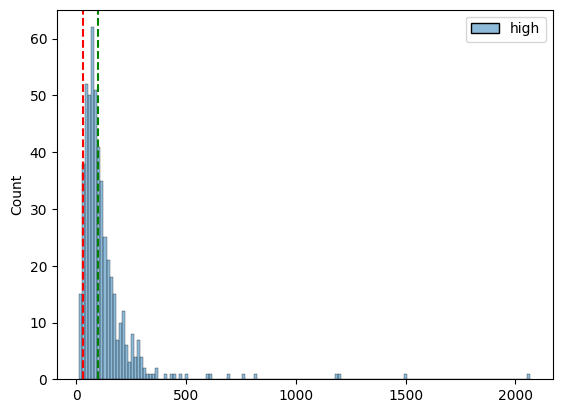

In [142]:
# Группы выбора на графике
import matplotlib.pyplot as plt
import seaborn as sns

high_max = pf_df[['high', 'Name']].groupby(['Name']).max()
sns.histplot(data=high_max, bins=150)
plt.axvline(x=30, color='red', linestyle='--')
plt.axvline(x=100, color='green', linestyle='--')

In [143]:
pf_df1 = high_max[high_max['high'] <= 30].sample(5)
pf_df2 = high_max[high_max['high'].between(30, 100, inclusive='right')].sample(5)
pf_df3 = high_max[high_max['high'] > 100].sample(10)
#pf_df3
#pf_df[pf_df['high']high_max < 30]
#high_max[high_max['high'] < 30].sample(5)
pf_df[pf_df['Name'].isin(pf_df1.index)]['date'].value_counts()

date
2015-10-19    5
2015-10-20    5
2015-10-21    5
2015-10-22    5
2015-10-23    5
             ..
2013-06-12    2
2013-06-13    2
2013-06-14    2
2013-06-17    2
2013-06-18    2
Name: count, Length: 1259, dtype: int64

<Axes: ylabel='Frequency'>

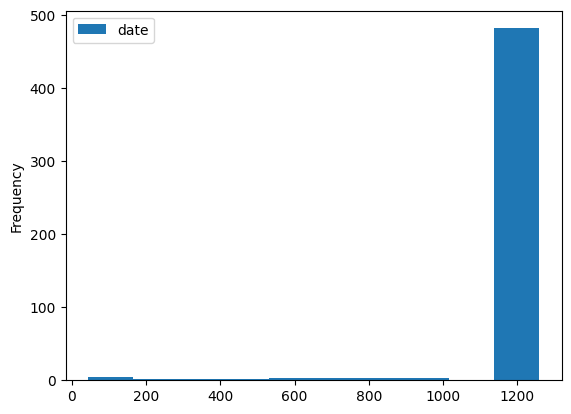

In [144]:
# Давайте узнаем как много организаций не имеют данных на полный период времени
pf_df[['date', 'Name']].groupby(['Name']).count().plot.hist()

In [145]:
# Попробуем использовать для исследования только полные данные.
dates = pf20_df['date'].sort_values().unique()
pf_df = pf_df.groupby(['Name']).filter(lambda x: x['date'].count() == len(dates))
high_max = pf_df[['high', 'Name']].groupby(['Name']).max()
pf_df1 = high_max[high_max['high'] <= 30].sample(5, random_state=1)
pf_df2 = high_max[high_max['high'].between(30, 100, inclusive='right')].sample(5, random_state=1)
pf_df3 = high_max[high_max['high'] > 100].sample(10, random_state=1)
pf20_df = pf_df[pf_df['Name'].isin(pf_df1.index)]
pf20_df['class'] = 'C'
pf20_df = pd.concat([pf20_df, pf_df[pf_df['Name'].isin(pf_df2.index)]], ignore_index=True).fillna('B')
pf20_df = pd.concat([pf20_df, pf_df[pf_df['Name'].isin(pf_df3.index)]], ignore_index=True).fillna('A')

Text(0.5, 0.925, 'Closing prices, $B')

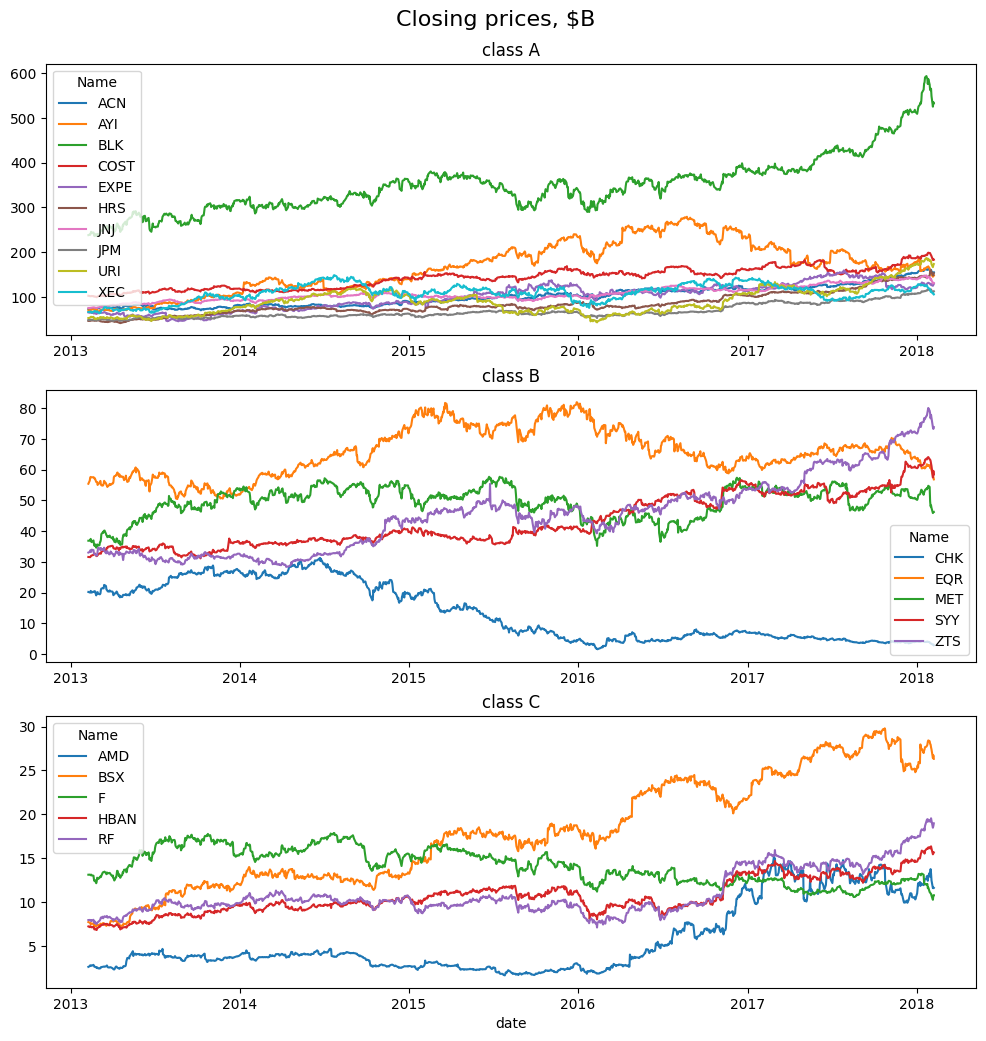

In [146]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
sns.lineplot(data=pf20_df[pf20_df['class'] == 'A'], x='date', y='close', hue='Name', ax=ax[0]).set(xlabel=None, ylabel=None, title='class A')
sns.lineplot(data=pf20_df[pf20_df['class'] == 'B'], x='date', y='close', hue='Name', ax=ax[1]).set(xlabel=None, ylabel=None, title='class B')
sns.lineplot(data=pf20_df[pf20_df['class'] == 'C'], x='date', y='close', hue='Name', ax=ax[2]).set(ylabel=None, title='class C')
fig.suptitle('Closing prices, $B', fontsize=16, y=0.925)
#g = sns.FacetGrid(pf20_df.sort_values('class'), row='class', aspect=4.)
#g.map(sns.lineplot, 'date', 'high', 'Name')
#g.add_legend()

In [252]:
date80 = dates[int(0.8*len(dates))]
pf20train_df = pf20_df[pf20_df['date'] <= date80]
pf20test_df = pf20_df[pf20_df['date'] > date80]
len(pf20train_df) + len(pf20test_df) == len(pf20_df)

True

In [253]:
pf20train_df = pf20train_df[['date', 'close', 'Name']].pivot(index='date', columns='Name', values='close').sort_values('date')
pf20test_df = pf20test_df[['date', 'close', 'Name']].pivot(index='date', columns='Name', values='close').sort_values('date')

In [254]:
pf20train_df
pf20_df['date'].value_counts()

date
2013-02-08    20
2013-02-11    20
2013-02-12    20
2013-02-13    20
2013-02-14    20
              ..
2018-02-01    20
2018-02-02    20
2018-02-05    20
2018-02-06    20
2018-02-07    20
Name: count, Length: 1259, dtype: int64

In [255]:
pd.Timestamp('2018-02-07') - pd.Timestamp('2013-02-08')

Timedelta('1825 days 00:00:00')

In [256]:
pf20_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 25180 entries, 0 to 25179
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    25180 non-null  datetime64[us]
 1   open    25180 non-null  Float64       
 2   high    25180 non-null  Float64       
 3   low     25180 non-null  Float64       
 4   close   25180 non-null  Float64       
 5   volume  25180 non-null  Int64         
 6   Name    25180 non-null  string        
 7   class   25180 non-null  str           
dtypes: Float64(4), Int64(1), datetime64[us](1), str(1), string(1)
memory usage: 1.7 MB


In [257]:
# Вычислим дневную доходность
pf20train_df = pf20train_df.diff().div(pf20train_df.index.diff().days.to_series().to_list(), axis='index') / pf20train_df.shift(1)
pf20test_df = pf20test_df.diff().div(pf20test_df.index.diff().days.to_series().to_list(), axis='index') / pf20test_df.shift(1)

In [284]:
pf20train_df = pf20train_df.iloc[1:]
pf20test_df = pf20test_df.iloc[1:]
pf20train_df.info(), pf20test_df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 1005 entries, 2013-02-13 to 2017-02-08
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ACN     1005 non-null   Float64
 1   AMD     1005 non-null   Float64
 2   AYI     1005 non-null   Float64
 3   BLK     1005 non-null   Float64
 4   BSX     1005 non-null   Float64
 5   CHK     1005 non-null   Float64
 6   COST    1005 non-null   Float64
 7   EQR     1005 non-null   Float64
 8   EXPE    1005 non-null   Float64
 9   F       1005 non-null   Float64
 10  HBAN    1005 non-null   Float64
 11  HRS     1005 non-null   Float64
 12  JNJ     1005 non-null   Float64
 13  JPM     1005 non-null   Float64
 14  MET     1005 non-null   Float64
 15  RF      1005 non-null   Float64
 16  SYY     1005 non-null   Float64
 17  URI     1005 non-null   Float64
 18  XEC     1005 non-null   Float64
 19  ZTS     1005 non-null   Float64
dtypes: Float64(20)
memory usage: 184.5 KB
<class 'pandas.DataFrame'>
Da

(None, None)

<Axes: xlabel='Name', ylabel='annual daily returns'>

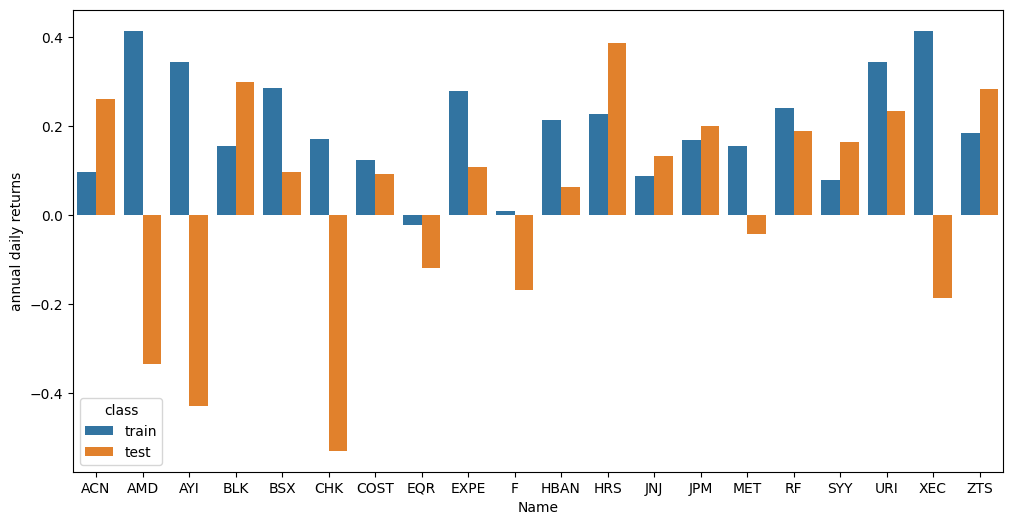

In [338]:
# Получаем годовые значения
pf20train_covann = pf20train_df.cov()*252
pf20test_covann = pf20test_df.cov()*252
pf20train_covann.max(axis=None)
pf20train_drann = pf20train_df.mean()*252
pf20test_drann = pf20test_df.mean()*252
pf20_drann = pf20train_drann.to_frame()
pf20_drann['class'] = 'train'
pf20_drann = pd.concat([pf20_drann, pf20test_drann]).fillna('test')
pf20_drann.columns = ['annual daily returns', 'class']
plt.figure(figsize=(12, 6))
sns.barplot(pf20_drann, x='Name', y='annual daily returns', hue='class')

Text(0.5, 0.95, 'Annualized covariance matrix for daily returns')

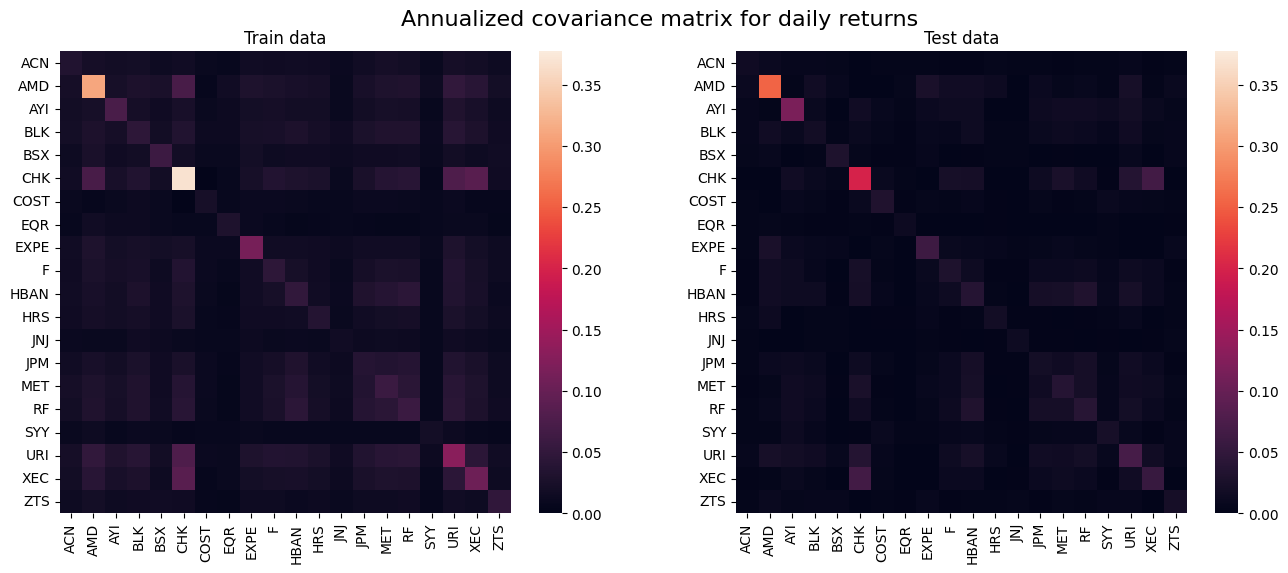

In [324]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
vmin = 0.0
vmax = 1.025 * max(pf20train_covann.max(axis=None), pf20test_covann.max(axis=None))
sns.heatmap(pf20train_covann, vmin=vmin, vmax=vmax, ax=ax[0]).set(xlabel=None, ylabel=None, title='Train data')
sns.heatmap(pf20test_covann, vmin=vmin, vmax=vmax, ax=ax[1]).set(xlabel=None, ylabel=None, title='Test data')
fig.suptitle('Annualized covariance matrix for daily returns', fontsize=16, y=0.95)

# QSVM vs SVM

## Dataset - "SME - Synthetic UK Businesses financial statistics"

### Описание

Информация о многих данных используемых в финансовом секторе недоступна рядовому пользователю. Финансовые организации, в погоне за прибылью, используют всю возможную информацию о своих клиентах, и редко ей делятся. Поэтому для исследований в таких областях как fraud detection или credit scoring часто используются синтетические данные, как в данном случае.

[Данный датасет](https://www.kaggle.com/datasets/nayaone/sme-uk-businesses-financial-statistics) содержит финансовую и базовую информацию о 1000 малых и средних предприятий Великобритании. В сумме он содержит более 200 аттрибутов, которые могут быть использованы для оценки выживаемости и успешности предприятий.

### Содержание

Датасеты, присутстующие в данном наборе:

    Account Receivable: Funds that customers owe your company for products or services that have been invoiced.
    Businesses: List of enterprises and their information
    Covid: Financial stats of the companies during the pandemic waves
    Credit Account History: History of a credit account and usage of
    Credit Card History: History of the credit card usage and debt amount of an enterprise
    Credit Rating: credit rating of listed businesses which is a quantified assessment of the creditworthiness of a borrower in general terms or with respect to a financial obligation.
    Director: UK Individual who is on the Director position in companies listed in Businesses
    Factoring: Financial transaction and a type of debtor finance in which a business sells its accounts receivable to a third party at a discount.
    Individual: UK Individuals information
    Loan: Information of the paid and unpaid Loans by the enterprise


In [148]:
import os
cds_ls = [pd.read_csv(os.path.join('./datasets/credit_scoring', f)) for f in os.listdir('./datasets/credit_scoring')]
cds_ls[0].info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1000 non-null   int64  
 1   borough_county                1000 non-null   str    
 2   address                       1000 non-null   str    
 3   contact_phone_no              1000 non-null   str    
 4   primary_sector                1000 non-null   str    
 5   entity_trade_name             1000 non-null   str    
 6   company_type                  1000 non-null   str    
 7   entity_name                   1000 non-null   str    
 8   company_reg_number            1000 non-null   int64  
 9   annual_turnover               1000 non-null   str    
 10  number_of_employees           1000 non-null   str    
 11  number_of_officers            1000 non-null   int64  
 12  incorporation_date            1000 non-null   str    
 13  entity_status  

# VQC

# [Grover's Algorithm]

# Conclusion